In [1]:
import os
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'
os.chdir('/workspace/FutureGPT2/src/')

from datasets import load_dataset, load_from_disk
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from itertools import islice
from collections import defaultdict
import re
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import gc
from matplotlib import pyplot as plt
import datasets
from torch.utils.data import DataLoader
import pandas as pd
from glob import glob
import gc

import lm_eval
from lm_eval.models.huggingface import HFLM

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [3]:
import logging
for name in logging.root.manager.loggerDict:
    for bad in ['transformers', 'huggingface', 'datasets', 'lm_evals', 'task', 'eval']:
        if bad in name:
            logging.getLogger(name).setLevel(logging.ERROR)        

In [4]:
def get_LM(model_name, myopic):
    '''
    Returns HFLM object
    '''
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/' + model_name)
    model = AutoModelForCausalLM.from_pretrained('EleutherAI/' + model_name).to('cuda')
    tag = 'MYOPIC' if myopic else 'VANILLA'
    g = f'/workspace/checkpoints/checkpoints_PYTHIA_UNSHARD/PYTHIA-PILE10M64-{tag}-fp16_model_name_{model_name}_*.ckpt'
    ckpt = glob(g)[0]
    state = torch.load(ckpt)['state_dict']
    model.load_state_dict({'.'.join(k.split('.')[1:]): v for k, v in state.items()})
    return HFLM(
        pretrained=model,
        tokenizer=tokenizer,
    )

In [11]:
tasks = [
    'lambada',
    'piqa',
    'winogrande',
    'wsc',
    'arc_easy',
    'arc_challenge',
    'sciq',
    'logiqa',
]
model_names = [
    'pythia-14m',
    'pythia-31m',
    'pythia-70m',
    'pythia-160m',
    'pythia-410m',
    'pythia-1b',
    'pythia-1.4b',
    'pythia-2.8b'
]
sizes = [
    1.4e7, 3.1e7, 7e7, 1.6e8, 4.1e8, 1e9, 1.4e9, 2.8e9
]
results = {}
for myopic in [False, True]:
    for model_name in model_names:
        gc.collect(); torch.cuda.empty_cache()
        tag = '_MYOPIC' if myopic else '_VANILLA'
        full_name = model_name + tag
        print(full_name)
        LM = get_LM(model_name, myopic)
        task_manager = lm_eval.tasks.TaskManager()
        results[full_name] = lm_eval.simple_evaluate(
            model=LM,
            tasks=tasks,
            num_fewshot=0,
            task_manager=task_manager,
            device='cuda',
        )

In [16]:
results['pythia-2.8b_VANILLA']['results']['piqa'].keys()

dict_keys(['acc,none', 'acc_stderr,none', 'acc_norm,none', 'acc_norm_stderr,none', 'alias'])

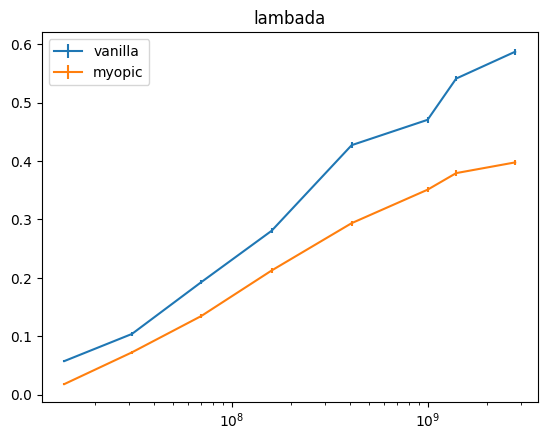

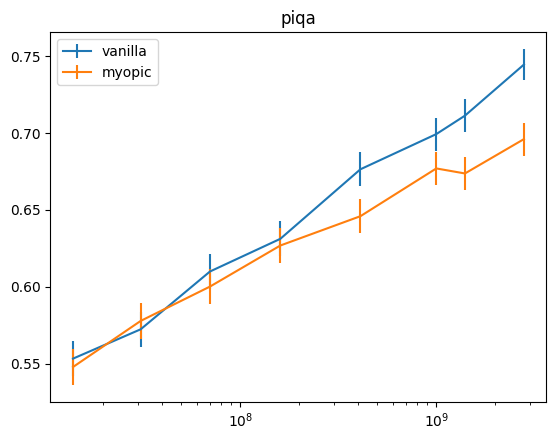

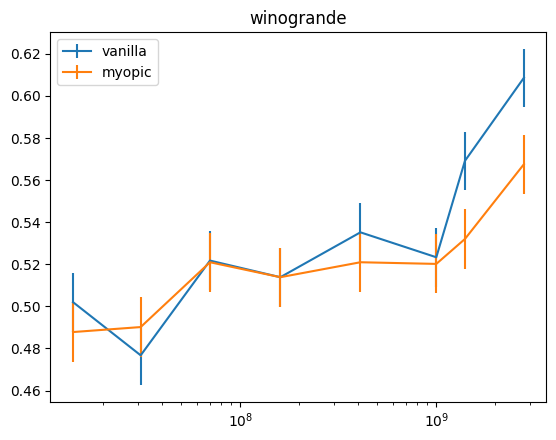

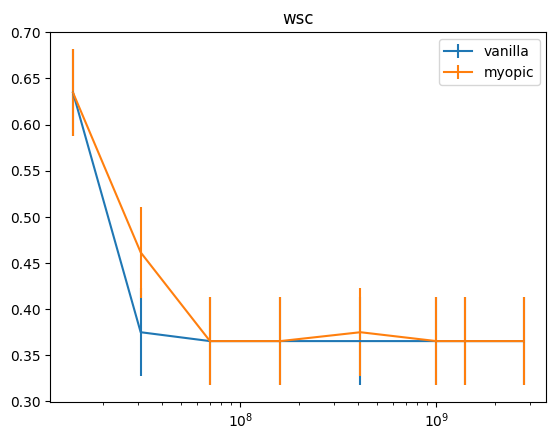

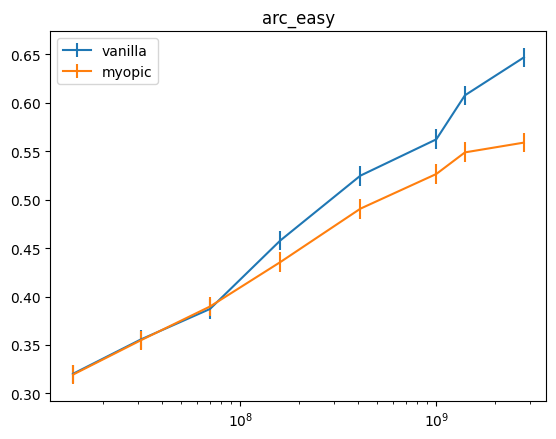

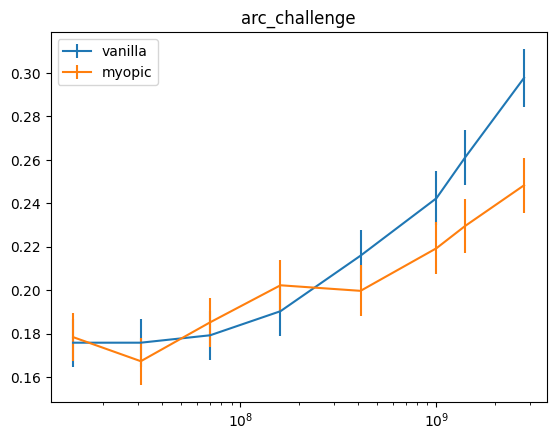

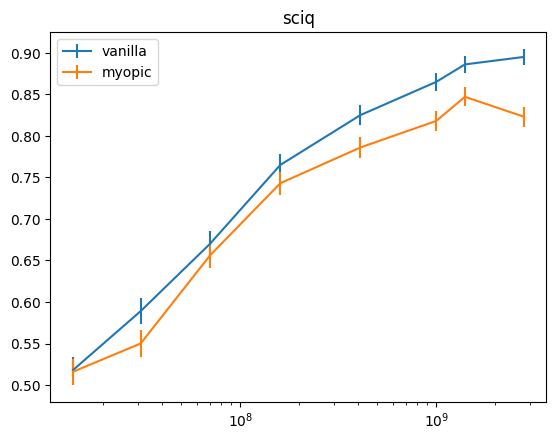

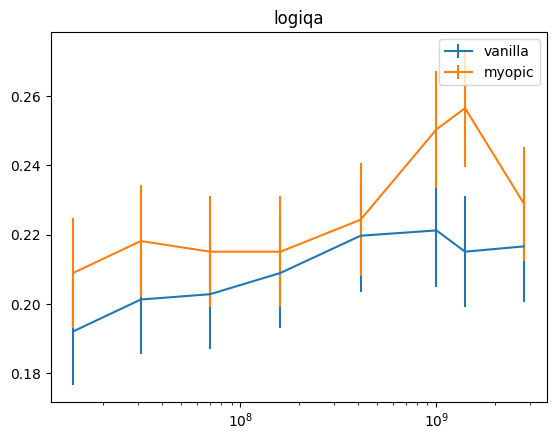

In [18]:
for task in tasks:
    vanilla_acc = [results[f'{m}_VANILLA']['results'][task]['acc,none'] for m in model_names]
    myopic_acc = [results[f'{m}_MYOPIC']['results'][task]['acc,none'] for m in model_names]
    vanilla_stderr = [results[f'{m}_VANILLA']['results'][task]['acc_stderr,none'] for m in model_names]
    myopic_stderr = [results[f'{m}_MYOPIC']['results'][task]['acc_stderr,none'] for m in model_names]
    plt.errorbar(sizes, vanilla_acc, vanilla_stderr, label='vanilla')
    plt.errorbar(sizes, myopic_acc, myopic_stderr, label='myopic')
    plt.xscale('log')
    plt.legend()
    plt.title(task)
    plt.show()

In [ ]:
for t in tasks:
    print(t)
    van = vanilla_results['results'][t]['acc,none']
    myo = myopic_results['results'][t]['acc,none']
    print(f'VANILLA: {van:.2f}')
    print(f'MYOPIC:  {myo:.2f}')
    print(f'DIFF:    {van-myo:.2f}')
    print()

In [7]:
import pickle

with open('/workspace/data/ALL_lm_eval.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
myopic_results['samples']['wsc']

In [19]:
!ls /workspace/data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ALL_lm_eval.pickle		   pos_v_loss_pythia_2.8b_vanilla.npy
fig				   pos_v_loss_standard.npy
pos_v_loss.npy			   pos_v_loss_standard_fixed.npy
pos_v_loss_myopic.npy		   pythia_2.8b_myopic_lm_eval.pickle
pos_v_loss_myopic_fixed.npy	   pythia_2.8b_vanilla_lm_eval.pickle
pos_v_loss_pythia_2.8b_myopic.npy  syth_neuron_r2_p0.3.npy
pos_v_loss_pythia_2.8b_orig.npy    syth_neuron_r2_p0.3_myopic.npy
